In [1890]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import special
from scipy.integrate import solve_ivp
from scipy import constants

In [1891]:
# Conditions
V0 = 750 # Vmax (V)
f0 = 50000 # RF frequency (Hz)
w0 = 2 * np.pi * f0 # Angular frequency
dgap = 1e-4 # gap length (m)
ddiel = 1e-4 # dielectric thickness (m)
dplate = 0.1 # Plate diameter (m)
As = 0.25 * np.pi * dplate**2 # Plate area (m2)
P = 1 # pressure (atm)
T = 400 # Temperature (K)


In [1892]:
# Parameters
epsr = 10 # relative permittivity
eps0 = 8.8541878128e-12 # vacuum permittivity (F/m)
type_EEDF = 1 # 1:Maxwellian EEDF, 2:Druyvesteyn EEDF, 1~2: Generalized EEDF
me = constants.electron_mass # electron mass (kg)
qe = constants.elementary_charge # electron charge (C)
NA = constants.Avogadro # Avogadro number (1/mol)
R = 8.2057366e-5 # gas constant (m3-atm/K/mol)
kb = constants.Boltzmann # Boltzmann constant (J/K)
F = 96485.33289 #Faraday constant (C/mol)
z_Ar1p = 1 # Charge of Ar ion

In [1893]:
# Properties
Mw_AR = 40/1000 # kg/mol
sigma_AR = 3.33e-10 # m, Ar potential characteristic length

In [1894]:
# Electron Collision Reaction Source Treatment
with open('Ar_xsecs.txt', 'r') as file:
    data = file.read()
    file.close()

In [1895]:
# Cross-section area Data Generation
rawD = data.split('\n')
rawD = [x for x in rawD if x != '']

reaction_index = []
for i in range(len(rawD)):
    if rawD[i].startswith('Type'):
        reaction_index.append(i)

R_type = list(range(len(reaction_index)))
R_eqn = list(range(len(reaction_index)))
R_Eloss = list(range(len(reaction_index)))
R_ext = list(range(len(reaction_index)))
R_Elevel = []
R_crossA = []
for i, name in enumerate(reaction_index):
    R_type[i] = rawD[name].split(' ')[1]
    R_eqn[i] = rawD[name+1]
    R_Eloss[i] = float(rawD[name+2].split(' ')[0])
    if R_type[i] == 'EXCITATION':
        R_ext[i] = float(rawD[name+2].split(' ')[2])
    else:
        R_ext[i] = 0
    if i != len(reaction_index) - 1:
        data_range = list(range(reaction_index[i]+5,reaction_index[i+1]-1))
        Elevel = list(range(len(data_range)))
        crossA = list(range(len(data_range)))
        iteration = 0
        for j in data_range:
            Elevel[iteration] = float(rawD[j].split(' ')[2])
            crossA[iteration] = float(rawD[j].split(' ')[4])
            iteration += 1
        R_Elevel.append(np.array(Elevel))
        R_crossA.append(np.array(crossA))
    else:
        data_range = list(range(reaction_index[i]+5,len(rawD)-1))
        Elevel = list(range(len(data_range)))
        crossA = list(range(len(data_range)))
        iteration = 0
        for j in data_range:
            Elevel[iteration] = float(rawD[j].split(' ')[2])
            crossA[iteration] = float(rawD[j].split(' ')[4])
            iteration += 1
        R_Elevel.append(Elevel)
        R_crossA.append(crossA)


In [1896]:
# Cross-section area interpolation function
from scipy import interpolate
def create_cross_section_interpolator(Elevel,crossA):
    def non_negative_interp(x):
        return np.maximum(0, interpolate.interp1d(Elevel, crossA, kind='cubic', fill_value='extrapolate')(x))
    return non_negative_interp

R_cross_interpolator = list(range(len(reaction_index)))
for i in range(len(reaction_index)):
    R_cross_interpolator[i] = create_cross_section_interpolator(R_Elevel[i],R_crossA[i])

def calculate_cross_section(interpolator, energy):
    return interpolator(energy)

In [1897]:
# upper incomplete gamma function
from scipy import special

def upper_incomplete_gamma(a):
    return special.gamma(a)

# EEDF calculation
def calculate_EEDF(type_EEDF,E,E_mean):
    g = type_EEDF
    beta1 = (upper_incomplete_gamma(5/(2*g)))**(3/2)*(upper_incomplete_gamma(3/(2*g)))**(-5/2)
    beta2 = upper_incomplete_gamma(5/(2*g))*upper_incomplete_gamma(3/(2*g))**(-1)
    return g*beta1*E_mean**(-3/2)*np.exp(-(E*beta2/E_mean)**g)

In [1898]:
e_grid = np.arange(0,100,0.01)

In [1899]:
# Rate Expression
def Rate_coeff(E_mean):
    R_coeff = list(range(len(R_Elevel)))
    for i in range(len(R_coeff)):
        EEDF = calculate_EEDF(type_EEDF,e_grid, E_mean)
        crossA = calculate_cross_section(R_cross_interpolator[i],e_grid)
        R_coeff[i] = np.sqrt(2 * qe / me) * np.trapz(EEDF * crossA * e_grid,e_grid)*NA
    return R_coeff


In [1900]:
# Detailed Balance for de-excitation process
index_excitation = [i for i, name in enumerate(R_type) if name == 'EXCITATION']
for i in index_excitation:
    eloss = R_Eloss[i]
    e = R_Elevel[i] - eloss + 1e-15
    sig = calculate_cross_section(R_cross_interpolator[i],R_Elevel[i])
    R_type.append('DE-EXCITATION')
    R_Elevel.append(e)
    R_crossA.append(1/R_ext[i]*(e+eloss)/e*sig)
    R_Eloss.append(-eloss)
    R_eqn.append(f'(rev){R_eqn[i]}')

iter = list(range(len(reaction_index),len(R_eqn)))

for j in iter:
    R_cross_interpolator.append(create_cross_section_interpolator(R_Elevel[j],R_crossA[j]))

In [1901]:
# Gas Phase Reaction
k_gas = []
# Ars + Ars => e + Ar + Ar+
R_type.append('Pooling')
R_eqn.append('Ars+Ars=>e+Ar+Ar1p')
R_Eloss.append(0)
k_gas.append(337340000) # forward rate constant (m3/s/mol)
# Ars + Ars => e + Ar + Ar+
R_type.append('Quenching')
R_eqn.append('Ars+Ar=>Ar+Ar')
R_Eloss.append(0)
k_gas.append(1807) # forward rate constant (m3/mol/s)

In [1902]:
def calculate_reaction_rates(R_eqn, k, concentrations):
    reaction_rates = []
    for i, eqn in enumerate(R_eqn):
        # 반응물과 생성물 분리
        reactants, products = eqn.split('=>')
        if 'rev' in reactants:
            reactants = products
        # 반응 속도 계산
        rate = k[i]
        for reactant in reactants.split('+'):
            reactant = reactant.strip()
            if reactant == 'e':
                rate *= concentrations['e']
            elif reactant == 'Ar':
                rate *= concentrations['Ar']
            elif reactant == 'Ars':
                rate *= concentrations['Ars']
            elif reactant == 'Ar1p':
                rate *= concentrations['Ar1p']
        
        reaction_rates.append(rate)
    
    return reaction_rates

In [1903]:
# plasma model
def model(t,y):
    ne, nAr, nArs, nAr1p, en, sigma = y
    
    # energy calculation
    V_applied = -V0 * np.cos(w0 * t)*0.5
    A = np.array([[-epsr/ddiel,1/dgap],[2,1]])
    B = np.array([sigma/eps0, V_applied])
    dVd, dVgap = np.linalg.solve(A,B)

    # electron energy
    E_mean = max(en/ne,0.01)
    # Component molar concentration
    conc = {
        'e': ne/NA,
        'Ar': nAr/NA,
        'Ars': nArs/NA,
        'Ar1p': nAr1p/NA
    }
    # reaction rate
    r = np.array(calculate_reaction_rates(R_eqn, Rate_coeff(E_mean)+k_gas,conc))

    # Collisional Power Loss
    Sen = 0
    for i in range(5):
        Sen += -r[i] * R_Eloss[i] * F

    # Inelastic collision frequency
    nue = 0
    for i in range(5):
        nue += r[i] / (ne/NA)
    # electron mobility
    mu_e = qe / (me*nue + 1e-30) 
    # electron temperature
    Te = max(2*en/(3*ne),1e-30)
    nue_th = np.sqrt(8*qe*Te/me/np.pi) #electron thermal velocity (m/s)
    ne_bnd = -0.5*ne*nue_th # electron density wall boundary condition
    en_bnd = -0.8333334 *en * nue_th
    # energy gain from electric field
    mflux = ne*mu_e*dVgap/dgap/2
    Pcap = qe*mflux*dVgap/dgap/2 # Capacitive power deposition
    

    dne_dt = (r[2] + r[3] + r[5]) * NA + ne_bnd
    dnAr_dt = (-r[1] - r[2] + r[4] + r[5] + r[6])*NA
    dnArs_dt = (r[1] - r[3] - r[4] - 2*r[5] - r[6])*NA
    dnAr1p_dt = (r[2] + r[3] + r[5])*NA
    dsig_dt = 0
    den_dt = Pcap/qe + Sen/qe + en_bnd

    return [dne_dt, dnAr_dt,dnArs_dt, dnAr1p_dt,den_dt, dsig_dt]

In [1904]:
# initialization
ne0 = 1e6
nAr0 = P/R/T*0.99999999999*NA
nArs0 = P/R/T*(1-0.99999999999)*NA
nAr1p0 = ne0
en0 =  5 * ne0
sig0 = 0

# 시간 그리드
tend= 1e-4
t_span = (1e-7,tend)

# 시뮬레이션 실행
sol = solve_ivp(model, t_span, [ne0,nAr0,nArs0,nAr1p0,en0,sig0], method='BDF')

c:\Python\Python312\Lib\site-packages\scipy\integrate\_ivp\common.py:346: RuntimeWarning: overflow encountered in multiply
  h_new = (y[ind] + new_factor * y_scale[ind]) - y[ind]
c:\Python\Python312\Lib\site-packages\scipy\integrate\_ivp\common.py:315: RuntimeWarning: overflow encountered in multiply
  h = (y + factor * y_scale) - y
c:\Python\Python312\Lib\site-packages\scipy\integrate\_ivp\common.py:345: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
c:\Python\Python312\Lib\site-packages\scipy\integrate\_ivp\common.py:367: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


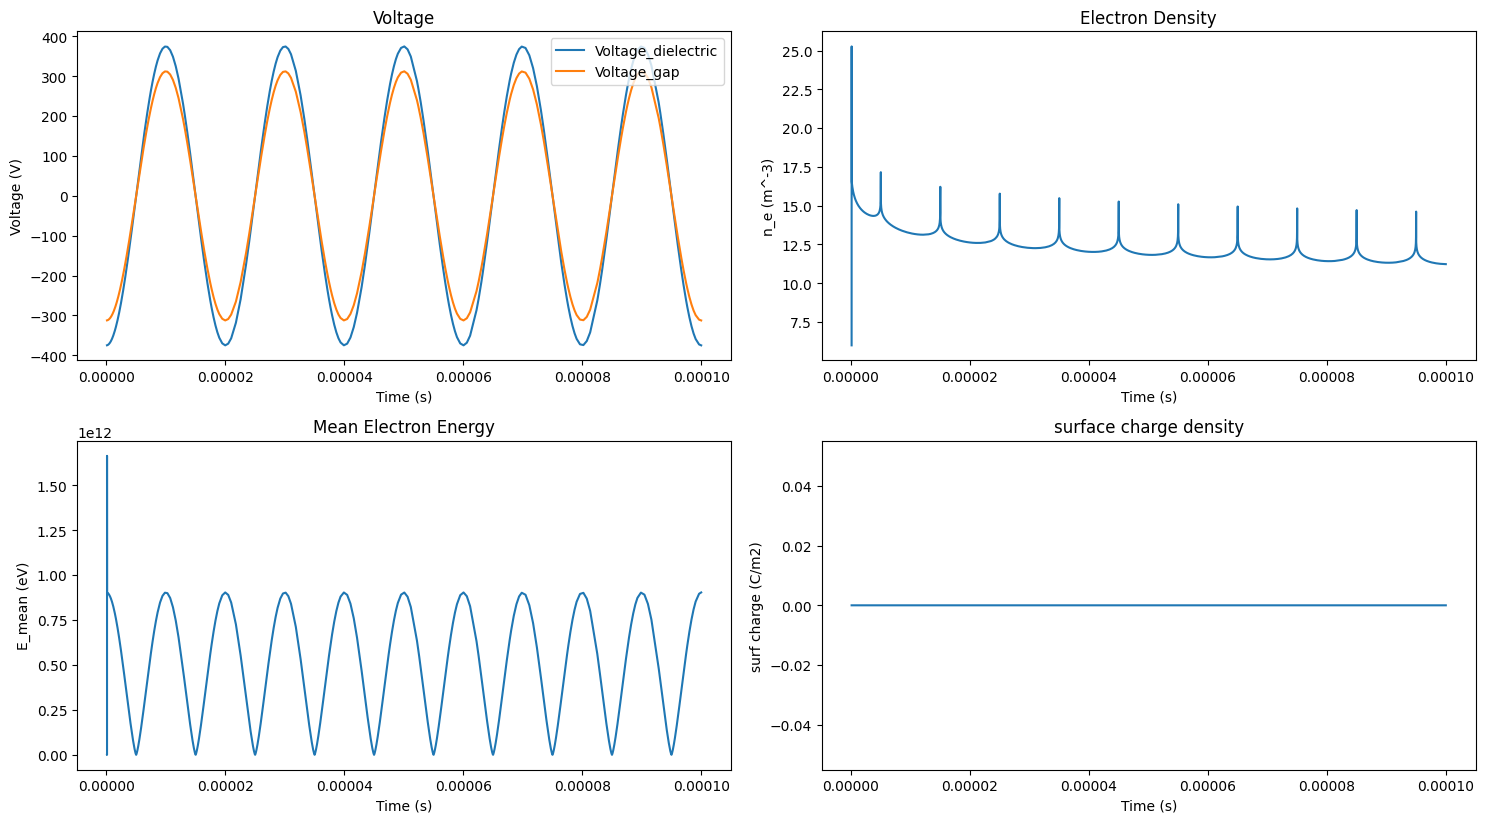

In [1905]:
# 결과 플로팅
plt.figure(figsize=(15, 12))

plt.subplot(321)
V_applied = -V0 * np.cos(w0 * sol.t)*0.5
A = np.array([[-epsr/ddiel,1/dgap],[2,1]])
B = np.array([sol.y[5]/eps0, V_applied])
dVd, dVgap = np.linalg.solve(A,B)
plt.plot(sol.t, V_applied, label='Voltage_dielectric')
plt.plot(sol.t, dVgap, label='Voltage_gap')
plt.title('Voltage')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')

plt.subplot(322)
plt.plot(sol.t, np.log10(sol.y[0]))
plt.title('Electron Density')
plt.xlabel('Time (s)')
plt.ylabel('n_e (m^-3)')

plt.subplot(323)
plt.plot(sol.t, sol.y[4]/sol.y[0])
plt.title('Mean Electron Energy')
plt.xlabel('Time (s)')
plt.ylabel('E_mean (eV)')

plt.subplot(324)
plt.plot(sol.t, sol.y[5])
plt.title('surface charge density')
plt.xlabel('Time (s)')
plt.ylabel('surf charge (C/m2)')

plt.tight_layout()
plt.show()